In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('steam_reviews.csv')

In [6]:
dataset.columns

Index(['Unnamed: 0', 'app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')

In [7]:
dataset.shape

(21747371, 23)

# RQ2

### number of reviews for each application in descending order.

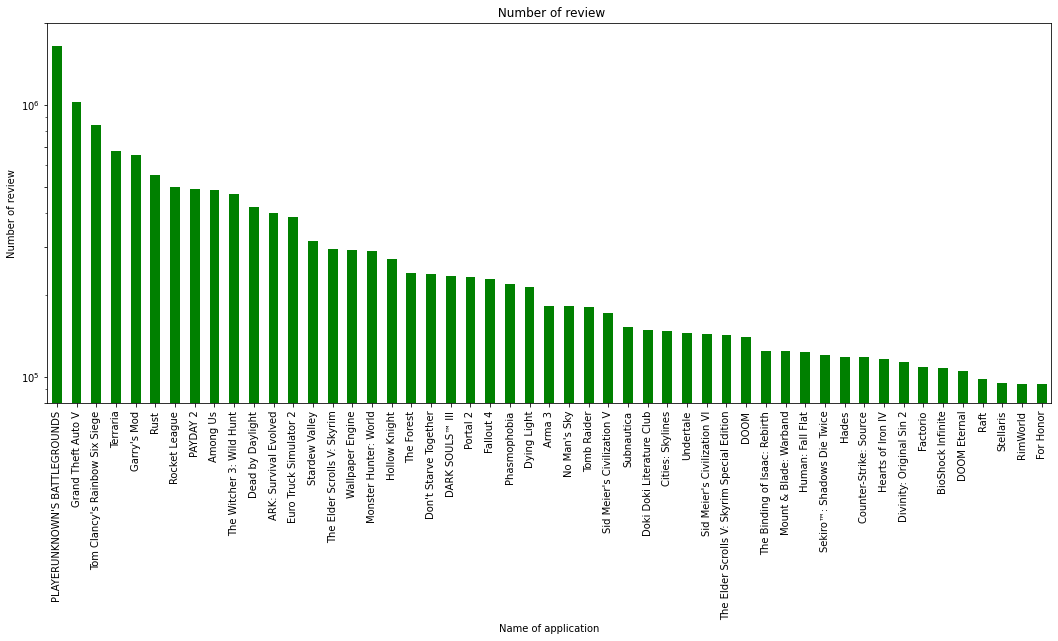

In [8]:
number_review = dataset.groupby("app_name").review_id.count().sort_values(ascending=False)
number_review[0:51].plot.bar(figsize = (18, 7), title=' Number of review', xlabel='Name of application',
ylabel='Number of review', color = "green", logy = True)
#plt.yticks([80000, 100000, 300000, 500000, 700000,1000000, 2000000])
#plt.show()


### Best Weighted Vote Score

In [9]:
massimi = pd.Series(dataset.groupby("app_name").weighted_vote_score.mean().sort_values(ascending=False).head(50))
#medie = dataset.groupby("app_name").weighted_vote_score.mean().sort_values(ascending=False).head(10)
massimi



app_name
Hunt Down The Freeman                   0.502150
Urban Empire                            0.438623
METAL GEAR SURVIVE                      0.421632
Identity                                0.415384
Umbrella Corps                          0.414678
Torment: Tides of Numenera              0.411199
BERSERK and the Band of the Hawk        0.397092
DRAGON QUEST HEROES™ II                 0.381110
X Rebirth                               0.380447
Toukiden 2                              0.380300
Warhammer 40,000: Dawn of War III       0.377935
DYNASTY WARRIORS 9                      0.371213
RollerCoaster Tycoon World              0.365161
Wolfenstein: Youngblood                 0.354932
Steel Division: Normandy 44             0.351986
SENRAN KAGURA Peach Beach Splash        0.347711
Clicker Heroes 2                        0.345768
Takedown: Red Sabre                     0.337137
Secret of Mana                          0.336822
Bless Online                            0.331621
Artifact   

### Which applications have the most and the least recommendations

In [76]:
#Most
new_data = dataset[(dataset.recommended == True)]
appp = pd.Series(new_data.groupby("app_name").recommended.count().sort_values(ascending=False).head(10))
appp

app_name
PLAYERUNKNOWN'S BATTLEGROUNDS     886417
Grand Theft Auto V                831311
Tom Clancy's Rainbow Six Siege    742397
Terraria                          658741
Garry's Mod                       632558
Rust                              468892
Among Us                          463287
The Witcher 3: Wild Hunt          460252
Rocket League                     449464
PAYDAY 2                          428136
Name: recommended, dtype: int64

In [85]:
#Least
new_data1 = dataset[(dataset.recommended == False)]
apppp = pd.Series(new_data1.groupby("app_name").recommended.count().sort_values(ascending=False).head(10))
apppp

app_name
PLAYERUNKNOWN'S BATTLEGROUNDS     757838
Grand Theft Auto V                187805
Tom Clancy's Rainbow Six Siege     99521
ARK: Survival Evolved              84766
Rust                               80182
Dead by Daylight                   73315
PAYDAY 2                           59611
No Man's Sky                       56537
Fallout 4                          49745
Rocket League                      49101
Name: recommended, dtype: int64

### How many of these applications were purchased, and how many were given for free?

Fra quelli che hanno ricevuto raccomandazioni positive quanti sono stati ceduti gratuitamente e quanti no

In [83]:
#Most
q = list(appp.index)
new_data = new_data[(new_data["app_name"].isin(q))]
new_data.groupby(["app_name", "received_for_free"]).recommended.count()

app_name                        received_for_free
Among Us                        False                442858
                                True                  20429
Garry's Mod                     False                608583
                                True                  23975
Grand Theft Auto V              False                796151
                                True                  35160
PAYDAY 2                        False                392454
                                True                  35682
PLAYERUNKNOWN'S BATTLEGROUNDS   False                842990
                                True                  43427
Rocket League                   False                432489
                                True                  16975
Rust                            False                450871
                                True                  18021
Terraria                        False                639147
                                True              

In [87]:
#Least
q = list(apppp.index)
new_data1 = new_data1[(new_data1["app_name"].isin(q))]
new_data1.groupby(["app_name", "received_for_free"]).recommended.count()

app_name                        received_for_free
ARK: Survival Evolved           False                 82992
                                True                   1774
Dead by Daylight                False                 70210
                                True                   3105
Fallout 4                       False                 49023
                                True                    722
Grand Theft Auto V              False                184341
                                True                   3464
No Man's Sky                    False                 55951
                                True                    586
PAYDAY 2                        False                 56880
                                True                   2731
PLAYERUNKNOWN'S BATTLEGROUNDS   False                739822
                                True                  18016
Rocket League                   False                 47824
                                True              

# RQ 3

In [5]:
def parsedate(time_as_a_unix_timestamp):
    return pd.to_datetime(time_as_a_unix_timestamp, unit = 's')


In [6]:
dataset = pd.read_csv('steam_reviews.csv', header='infer',
parse_dates=['timestamp_created',
'timestamp_updated', 'author.last_played'],
date_parser=parsedate)

In [100]:
def funzione(lista):
    lista = [datetime.strptime(t, '%H:%M:%S') for t in lista]
    sec_1 = []
    min_1 = []
    ora_1 = []
    number_review = []
    for i in range(len(lista)):
        sec_1.append(lista[i].time().second)
        min_1.append(lista[i].time().minute)
        ora_1.append(lista[i].time().hour)
    for i in range(0, len(lista), 2):
        number_review.append(dataset[(dataset.timestamp_created.dt.hour >= ora_1[i]) & (dataset.timestamp_created.dt.minute >= min_1[i]) & (dataset.timestamp_created.dt.second >= sec_1[i]) & (dataset.timestamp_created.dt.hour <= ora_1[i+1]) & (dataset.timestamp_created.dt.minute <= min_1[i+1]) & (dataset.timestamp_created.dt.second <= sec_1[i+1])].review_id.count())
    xx = ['6am', '11am', '2pm', '5pm', '8pm', '12am', '3am']
    plt.bar(xx, number_review, color = 'green')
    plt.yscale('log')
    plt.yticks([2000000, 2500000, 3000000, 3500000, 4000000])
    plt.title('Number of review for each interval of time')
    plt.xlabel('Intervals')
    plt.ylabel('Number of review')
    plt.show()
    
    
    
    

In [101]:
intervalli = ['06:00:00', '10:59:59', '11:00:00', '13:59:59', '14:00:00', '16:59:59',
        '17:00:00', '19:59:59', '20:00:00', '23:59:59', '00:00:00', '02:59:59', '03:00:00',
        '05:59:59']

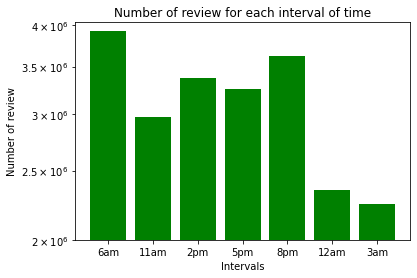

In [102]:
funzione(intervalli)

# RQ4

### What are the top 3 languages used to review applications?

il numero totale non coincide se conto review e non review_id questo perchè ci saranno dei nan

In [3]:
top_languages = pd.Series(dataset.groupby("language").review_id.count().sort_values(ascending=False).head(3))
top_languages

language
english     9635437
schinese    3764967
russian     2348900
Name: review_id, dtype: int64

In [10]:
top_languages = list(top_languages.index)
top_languages

['english', 'schinese', 'russian']

### Create a function that receives as parameters both the name of a data set and a list of languages’ names and returns a data frame filtered only with the reviews written in the provided languages.

In [13]:
def filtro(data, lingue):
    a = pd.DataFrame(columns = dataset.columns)
    for i in range(len(lingue)):
        a = pd.concat([a, data[data.language == lingue[i]]])
    return a

In [14]:
dataset_filter = filtro(dataset, top_languages)

In [15]:
dataset_filter

,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
3,3,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",1611379970,1611379970,True,0,...,True,False,False,76561199054755373,5,3,5587.0,3200.0,5524.0,1.611384e+09
5,5,292030,The Witcher 3: Wild Hunt,85184171,english,"good story, good graphics. lots to do.",1611379264,1611379264,True,0,...,True,False,False,76561198170193529,11,1,823.0,823.0,823.0,1.611379e+09
6,6,292030,The Witcher 3: Wild Hunt,85184064,english,"dis gud,",1611379091,1611379091,True,0,...,True,False,False,76561198119302812,27,2,4192.0,3398.0,4192.0,1.611352e+09
18,18,292030,The Witcher 3: Wild Hunt,85180436,english,favorite game of all time cant wait for the Ne...,1611373086,1611373086,True,0,...,True,False,False,76561198065591528,33,1,23329.0,177.0,23329.0,1.611219e+09
20,20,292030,The Witcher 3: Wild Hunt,85179753,english,Why wouldn't you get this,1611371978,1611371978,True,0,...,True,False,False,76561198996835044,131,2,8557.0,2004.0,8557.0,1.611371e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21747303,21747308,546560,Half-Life: Alyx,65646232,russian,Играю на Oculus Quest без проводов с помощью v...,1584987806,1585146937,True,161,...,True,False,False,76561198049248207,645,56,886.0,0.0,65.0,1.610130e+09
21747306,21747311,546560,Half-Life: Alyx,65646184,russian,Игра десятилетия,1584987754,1584987754,True,0,...,True,False,False,76561198307009705,57,1,1450.0,0.0,48.0,1.596121e+09
21747325,21747330,546560,Half-Life: Alyx,65646020,russian,"Красивая графика, интересный сюжет, разный вар...",1584987605,1584987605,True,0,...,True,False,False,76561197993320811,443,9,585.0,0.0,66.0,1.588512e+09
21747330,21747335,546560,Half-Life: Alyx,65645878,russian,"Это настоящая халва, кто еще не купил шлем ВР ...",1584987450,1585163194,True,0,...,True,False,False,76561197994263612,81,4,1951.0,0.0,171.0,1.599850e+09


### Use the function created in the previous literal to find what percentage of these reviews (associated with the top 3 languages) were voted as funny?

trovo le percentuali di recensioni trovate divertenti per ogni lingua tipo fra quelle scritte in inglese ce ne sono l' 11.27 %. poi scrivi bene risultato

In [16]:
numeratore = []
denominatore = []
rapporto = []
for i in range(len(top_languages)):
    numeratore.append(dataset_filter[(dataset_filter.votes_funny != 0) & (dataset_filter.language == top_languages[i])].votes_funny.count())
    denominatore.append(dataset_filter[dataset_filter.language == top_languages[i]].votes_funny.count())
    rapporto.append(round((numeratore[i]/denominatore[i])*100, 2))

rapporto

[11.27, 11.82, 16.68]

mi dà la percentuale di quanti reviews sono state trovate divertenti fra tutte e tre le lingue

In [18]:
num = dataset_filter[dataset_filter.votes_funny != 0].votes_funny.count()
den = dataset_filter.votes_funny.count()
round((num/den)*100, 2)

12.21

In [20]:
#num = i vari elementi di numeratori

1922726

In [21]:
numeratore


[1085997, 444945, 391784]

In [22]:
den

15749304

### Use the function created in the literal “a” to find what percentage of these reviews (associated with the top 3 languages) were voted as helpful?

In [23]:
numeratore = []
denominatore = []
rapporto = []
for i in range(len(top_languages)):
    numeratore.append(dataset_filter[(dataset_filter.votes_helpful != 0) & (dataset_filter.language == top_languages[i])].votes_helpful.count())
    denominatore.append(dataset_filter[dataset_filter.language == top_languages[i]].votes_helpful.count())
    rapporto.append(round((numeratore[i]/denominatore[i])*100, 2))

rapporto

[29.2, 25.1, 35.5]

In [24]:
num = dataset_filter[dataset_filter.votes_helpful != 0].votes_helpful.count()
den = dataset_filter.votes_helpful.count()
round((num/den)*100, 2)

29.16

In [25]:
numeratore

[2813873, 945157, 833896]

In [26]:
num

4592926